# Explore here

In [1]:
# Your code here
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import warnings

In [2]:
# Get data
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [3]:
df.shape

(366, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [5]:
df.index.to_series().diff().value_counts()

1.0    365
Name: count, dtype: int64

- Dar formato datetime, necesario para entrenar el modelo.

In [6]:
df["date"] = pd.to_datetime(df["date"])

df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


## Visualizar la serie temporal

In [7]:
ts = df['sales']

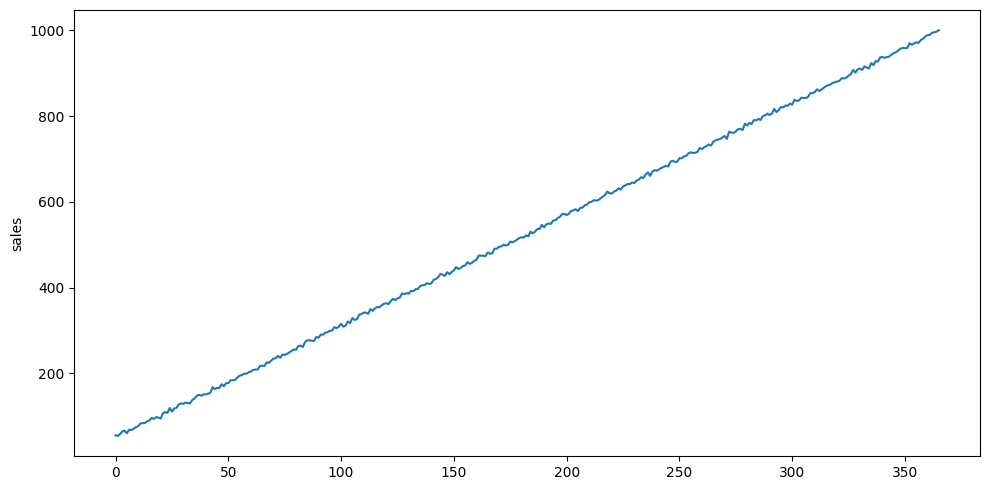

In [8]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

## Descomposición de la serie

In [9]:
decomposition = seasonal_decompose(ts, period = 30)
decomposition

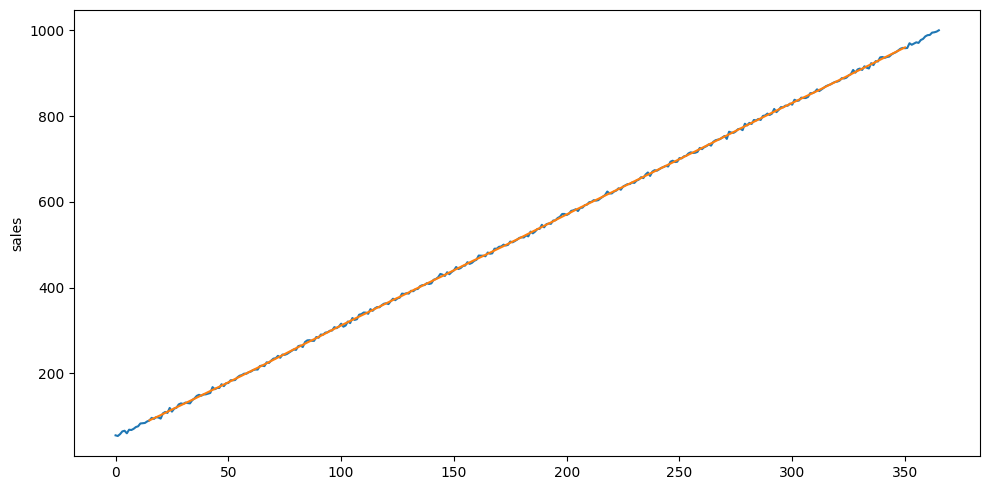

In [10]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

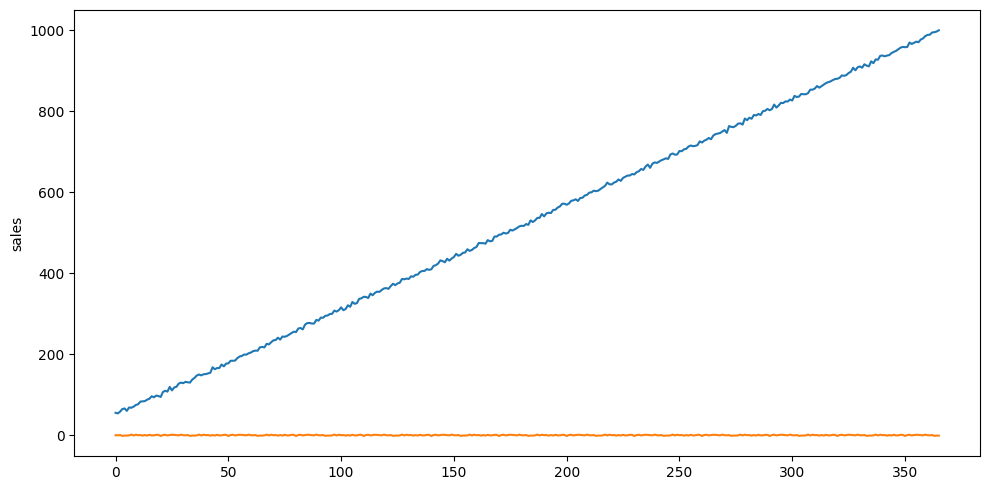

In [11]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

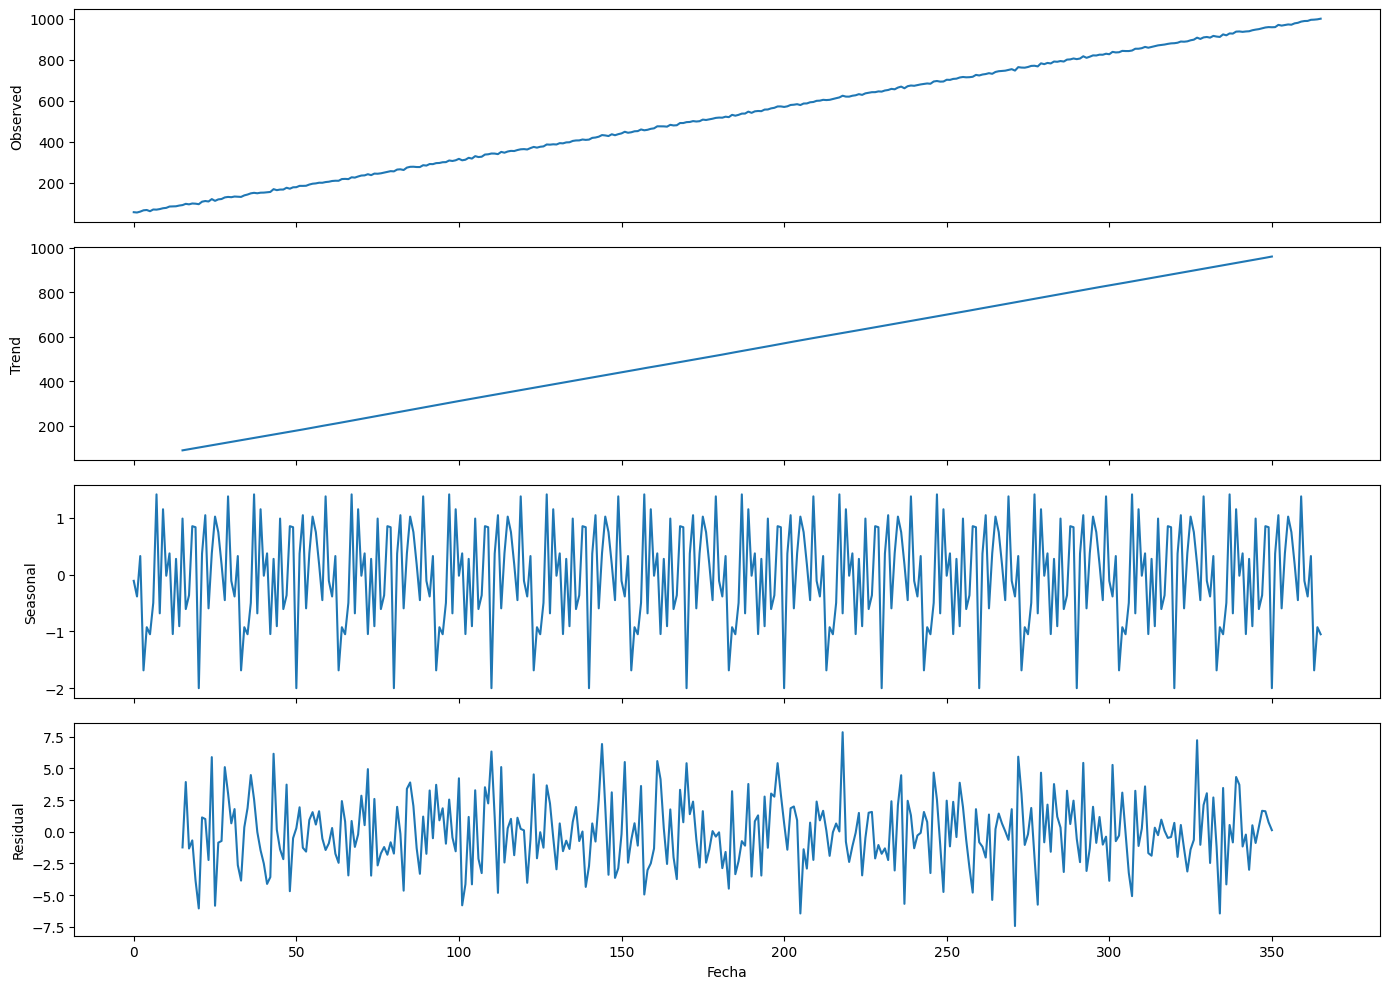

In [12]:

# Graficar los componentes de la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel("Observed")

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel("Trend")

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel("Seasonal")

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel("Residual")

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

- ¿Cuál es la tendencia? 
    - Se puede observar en el grafico que la tendencia es alcista. 
- ¿Existe variabilidad o presencia de ruido?
    - Sí hay presencia de ruido, pero está bien distribuido.
- ¿Cuál es el tensor de la serie temporal? 
    - El tensor de la serie temporal es anual (1 año con observaciones diarias).


## Verificar estacionariedad

In [13]:


def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Si el p-value > 0.05, la serie no es estacionaria → necesitamos diferenciarla.

## Estabilizar la serie 

In [14]:
ts_diff = ts.diff().dropna()


In [15]:
test_stationarity(ts_diff)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

## Identificar los parámetros ARIMA (p, d, q)

- ACF/PACF plots manualmente

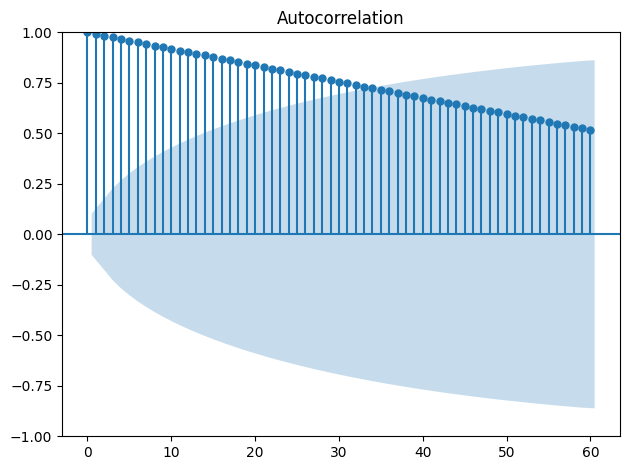

In [16]:
plot_acf(ts, lags=60)

plt.tight_layout()

plt.show()

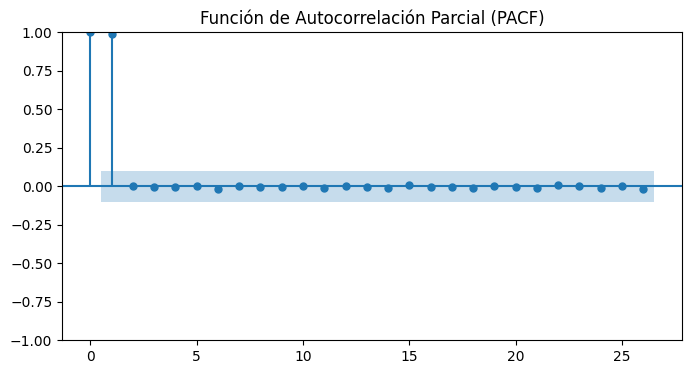

In [17]:
# Graficar PACF
plt.figure(figsize=(8, 4))
plot_pacf(ts, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

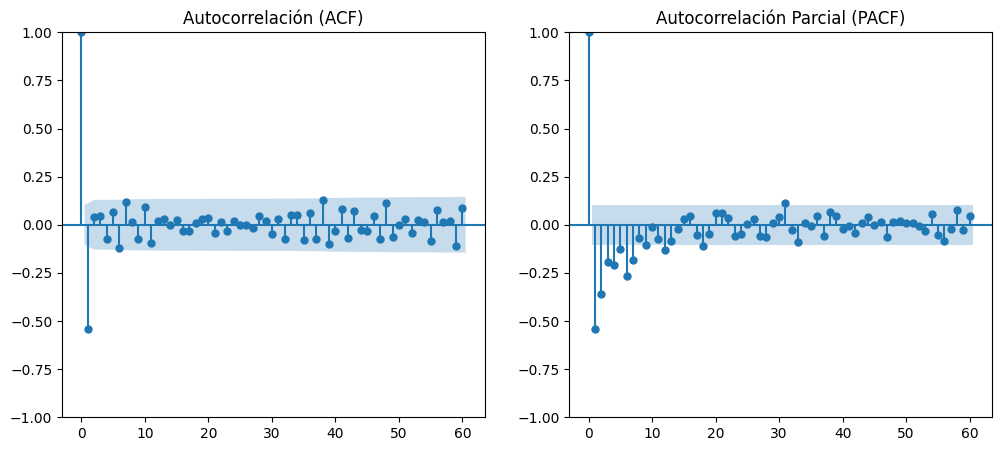

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ACF para determinar q
plot_acf(ts_diff, lags=60, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

# PACF para determinar p
plot_pacf(ts_diff, lags=60, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()

## Entrenar el modelo

In [19]:
p = 1
d = 1
q = 1

modelo_arima = ARIMA(ts, order=(p,d,q))

resultado_arima = modelo_arima.fit()

In [20]:
# Pronóstico para los próximos 15 días
predicciones = resultado_arima.predict(start=len(ts), end=len(ts)+14)
predicciones

366    1003.052388
367    1005.621989
368    1008.191589
369    1010.761187
370    1013.330783
371    1015.900378
372    1018.469971
373    1021.039562
374    1023.609152
375    1026.178740
376    1028.748327
377    1031.317912
378    1033.887495
379    1036.457077
380    1039.026657
Name: predicted_mean, dtype: float64

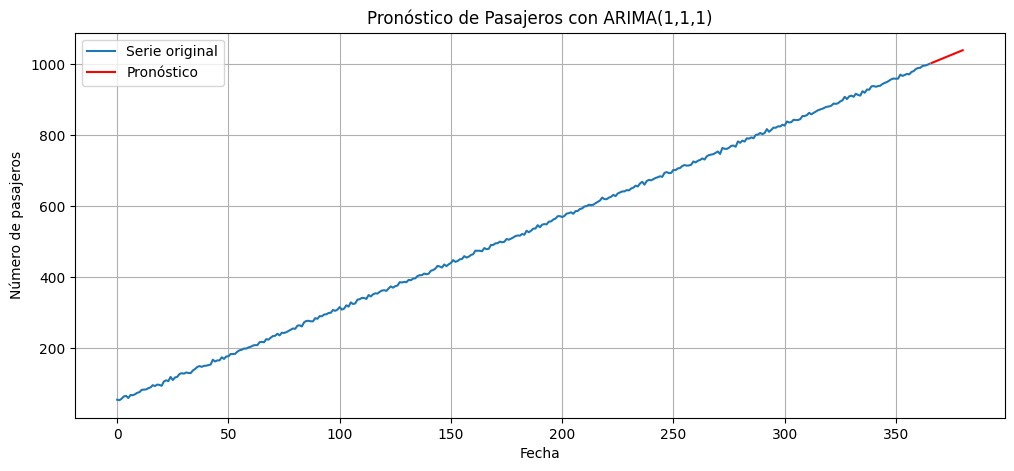

In [21]:
# Graficar pronóstico
plt.figure(figsize=(12,5))
plt.plot(ts, label='Serie original')
plt.plot(predicciones, label='Pronóstico', color='red')
plt.title("Pronóstico de Pasajeros con ARIMA(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")
plt.legend()
plt.grid(True)
plt.show()

- auto_arima para sugerencia automática

In [22]:
model = auto_arima(ts_diff, seasonal = True, trace = True, m = 30)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1845.252, Time=3.54 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.01 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=0.53 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2209.657, Time=0.01 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1843.274, Time=3.10 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=1843.049, Time=0.38 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=1843.222, Time=2.13 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=1843.587, Time=0.18 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=1841.533, Time=0.74 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC=1921.468, Time=1.19 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=1841.425, Time=1.92 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=3.20 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[30] intercept   : AIC=1843.425, Time=10.76 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[30] intercept   : AIC=inf, Time=13.44 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=1839.439, Time=2.95 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=1839.553, Time=1.61 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=1841.606, Time=5.19 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[30] intercept   : AIC=1841.438, Time=7.88 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=1839.455, Time=6.54 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[30] intercept   : AIC=1843.428, Time=24.86 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=1971.866, Time=0.49 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[30] intercept   : AIC=inf, Time=2.87 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[30] intercept   : AIC=2097.710, Time=0.48 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[30] intercept   : AIC=1839.497, Time=1.97 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=1922.182, Time=0.86 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[30]             : AIC=inf, Time=1.76 sec

Best model:  ARIMA(1,0,1)(0,0,1)[30] intercept
Total fit time: 100.182 seconds


In [23]:
forecast = model.predict(15)
forecast

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


365    2.046149
366    2.162499
367    2.827505
368    2.042483
369    2.743390
370    2.940540
371    2.700119
372    2.713957
373    2.406173
374    2.549262
375    2.623742
376    2.473212
377    2.492436
378    2.652892
379    2.882323
dtype: float64

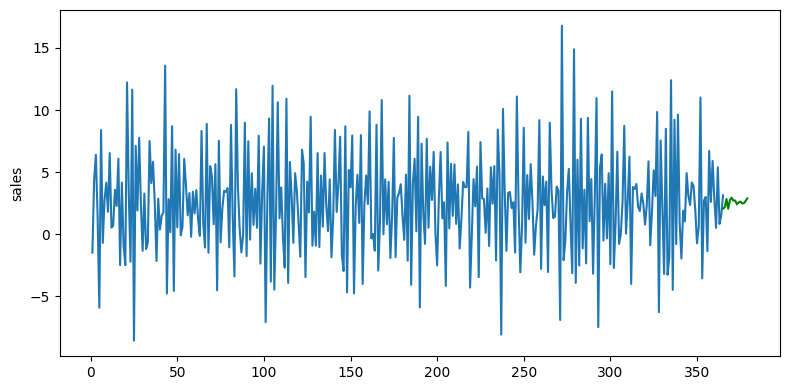

In [24]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = ts_diff)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [25]:
# Último valor de la serie original antes de diferenciar
last_value = ts.iloc[-1]

# Reconstruir las predicciones a partir del último valor conocido
forecast_original_scale = forecast.cumsum() + last_value

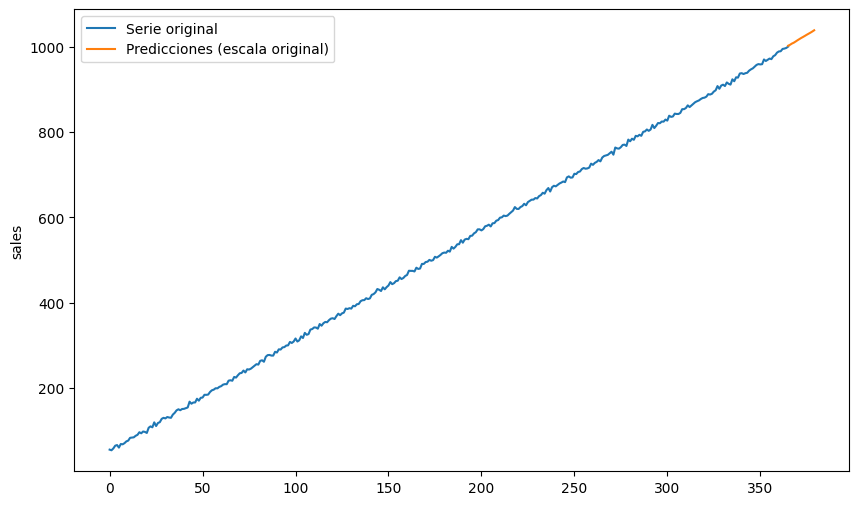

In [26]:
plt.figure(figsize=(10, 6))

# Serie original
sns.lineplot(data=ts, label="Serie original")

# Predicciones en la escala original
sns.lineplot(data=forecast_original_scale, label="Predicciones (escala original)")

plt.legend()
plt.show()

## Guardar modelo

In [27]:
from pickle import dump

dump(model, open("/workspaces/TIME_SERIES_FORECASTING_JesusCastanedam/models/model_auto_arima.sav", "wb"))
dump(modelo_arima, open("/workspaces/TIME_SERIES_FORECASTING_JesusCastanedam/models/model_arima_1.1.1.sav", "wb"))